In [2]:
import os
import sys
import pathlib
import numpy as np
import pandas as pd
import platform

In [3]:
if platform.system() == 'Windows':
    pathlib.PosixPath = pathlib.WindowsPath

In [4]:
sys.path.append(os.path.abspath(".."))

In [5]:
from src.preprocessing.catalog_reader import read_catalog
from src.preprocessing.param_scheme_reader import get_dist_from_scheme
from src.sst.storm_sampler import sample_storms
from src.utils_spatial.spatial_stats import get_sp_stats
from src.stats.distribution_helpers import truncnorm_params, fit_rotated_normal_to_polygon
from src.stats.distributions import TruncatedGeneralizedNormal, TruncatedDistribution, MixtureDistribution, RotatedNormal
from src.sst.sst_simulation import simulate_sst
from src.evaluation.sampling_eval import print_sim_stats
from src.evaluation.plotting import plot_sample_centers, plot_xy_vs_depth, plot_xy_vs_depth_2d, plot_freq_curve

In [6]:
# Select Watershed
name_watershed = ['Duwamish', 'Kanawha', 'Trinity',"RayRoberts"][3]
folder_watershed = rf'../data/1_interim/{name_watershed}'
os.chdir(folder_watershed)
cwd = pathlib.Path.cwd()

In [7]:
# Read watershed, domain, and storm catalogue
sp_watershed, sp_domain, df_storms = read_catalog(cwd)
df_storms = df_storms.assign(path = lambda _: _.path.apply(lambda _x: _x.absolute()))

Reprojecting polygon from EPSG:4326 to EPSG:5070 for rioxarray...
Reprojecting polygon from EPSG:4326 to EPSG:5070 for rioxarray...


In [8]:
# Get polygon info (bounds, centroids, ranges)
v_watershed_stats = get_sp_stats(sp_watershed)
v_domain_stats = get_sp_stats(sp_domain)

In [17]:
#Set number of simulations
n_sim_mc = 1_000_000
n_sim_is = 1_000_0

In [18]:
df_depths_mc_0, df_prob_mc_0, df_aep_mc_0 = simulate_sst(sp_watershed, sp_domain, df_storms, dist_x=None, dist_y=None, num_simulations=n_sim_mc)
df_depths_mc_0.to_pickle(cwd/'pickle'/f'df_depths_mc_0.pkl')
df_prob_mc_0.to_pickle(cwd/'pickle'/f'df_prob_mc_0.pkl')
df_aep_mc_0.to_pickle(cwd/'pickle'/f'df_aep_mc_0.pkl')

Computing depths: 100%|██████████| 1000000/1000000 [32:04<00:00, 519.53it/s]


In [19]:
# Run Monte Carlo for comparison
df_depths_mc, df_prob_mc, df_aep_mc = simulate_sst(sp_watershed, sp_domain, df_storms, dist_x=None, dist_y=None, num_simulations=n_sim_is)
df_depths_mc.to_pickle(cwd/'pickle'/f'df_depths_mc_n_{n_sim_is}.pkl')
df_prob_mc.to_pickle(cwd/'pickle'/f'df_prob_mc_n_{n_sim_is}.pkl')
df_aep_mc.to_pickle(cwd/'pickle'/f'df_aep_mc_n_{n_sim_is}.pkl')

Computing depths:   0%|          | 0/10000 [00:00<?, ?it/s]

Computing depths: 100%|██████████| 10000/10000 [00:19<00:00, 506.82it/s]


In [20]:
#region Set Importance Sampling Parameters
df_dist_params = pd.DataFrame(dict(
    dist = ['Truncated Normal + Uniform'],
    acronym = ['tnXu'],
    param_1_name = ['std'],
    param_1 = ['1'], # 1 for Duwamish, 0.5 for Kanahwa, 0.75 for Trinity
    param_2_name = ['w1'],
    param_2 = ['0.1'],
))

In [21]:
#region Update Importance Sampling Distribution Parameters
df_dist_params = \
(df_dist_params
    .assign(_p1 = lambda _: _.param_1.astype(str).str.replace(r'\.0$', '', regex=True))
    .assign(_p2 = lambda _: _.param_2.astype(str).str.replace(r'\.0$', '', regex=True))
    .assign(
        name_file = lambda _: _.acronym + '_' + _.param_1_name + '_' + _._p1 +
        np.where(_.param_2_name == '', '', '_' + _.param_2_name + '_' + _._p2)
    )
    .drop(columns=['_p1', '_p2'])
)
row_dist_params = df_dist_params.iloc[0]

In [22]:
# Get distribution
dist_x, dist_y = get_dist_from_scheme(row_dist_params, v_watershed_stats, v_domain_stats) 

Running for mult_std = 1.0, w1 = 0.1


In [23]:
# Run Importance Sampling
df_depths_is, df_prob_is, df_aep_is = simulate_sst(sp_watershed, sp_domain, df_storms, dist_x, dist_y, num_simulations=n_sim_is)
df_depths_is.to_pickle(cwd/'pickle'/f'df_depths_is_n_{n_sim_is}_{row_dist_params.name_file}.pkl')
df_prob_is.to_pickle(cwd/'pickle'/f'df_prob_is_n_{n_sim_is}_{row_dist_params.name_file}.pkl')
df_aep_is.to_pickle(cwd/'pickle'/f'df_aep_is_n_{n_sim_is}_{row_dist_params.name_file}.pkl')

Computing depths:   0%|          | 0/10000 [00:00<?, ?it/s]

Computing depths: 100%|██████████| 10000/10000 [00:20<00:00, 493.71it/s]


504
359
346


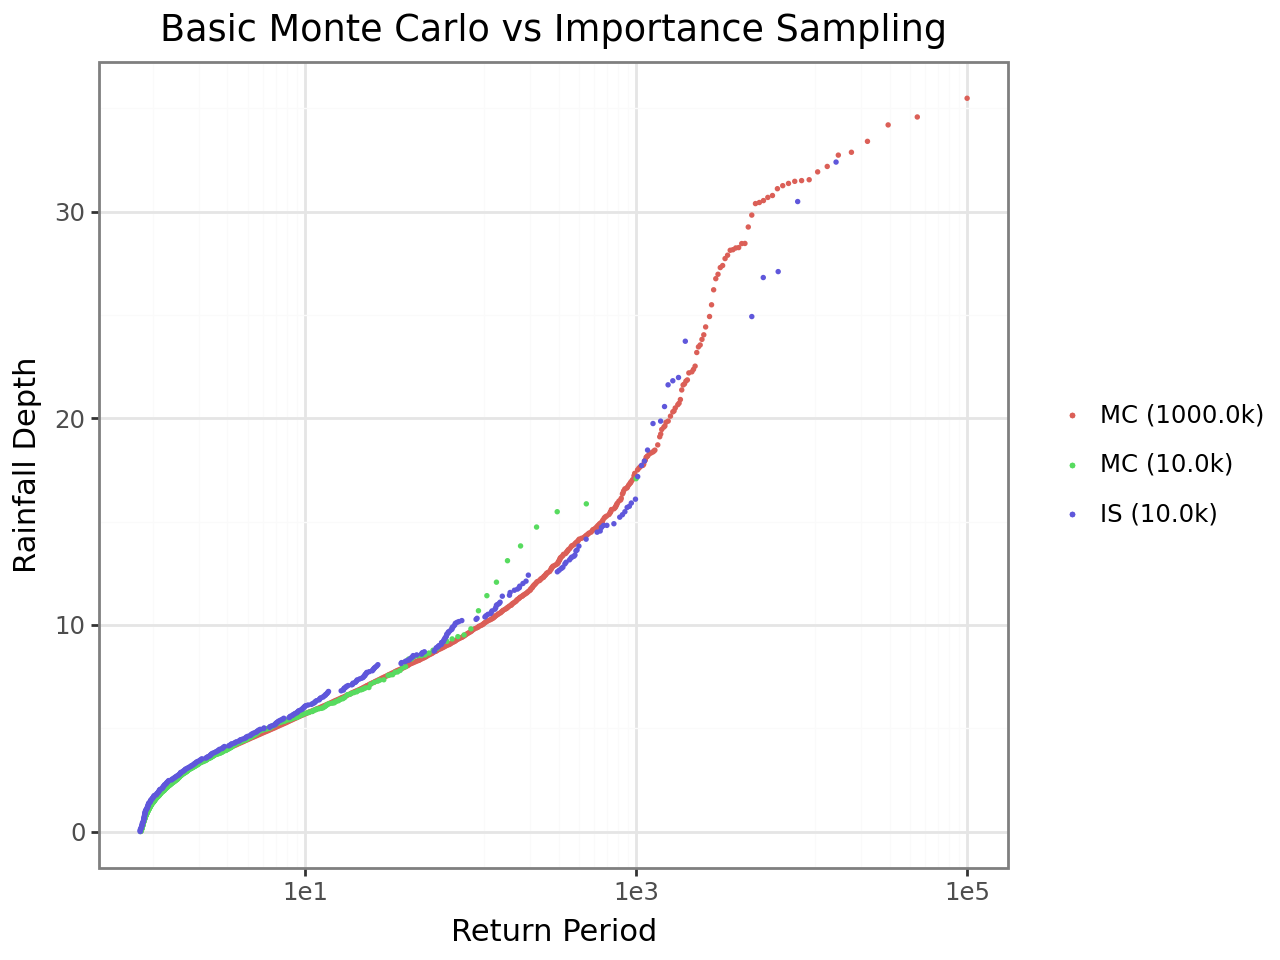

In [24]:
# Plot frequency curves
g = plot_freq_curve([df_prob_mc_0, df_prob_mc, df_prob_is], [f'MC ({n_sim_mc/1000}k)', f'MC ({n_sim_is/1000}k)', f'IS ({n_sim_is/1000}k)'])
g.show()
# g.save(cwd/'plots'/f'Freq n_{n_sim_is} {row.name_file}.png', width=10, height=7)

In [101]:
from typing import Literal

import numpy as np
import pandas as pd

import plotnine as pn
def plot_freq_curve(
    l_df_prob, 
    l_names, 
    l_colors=None, 
    var_x: Literal['return_period', 'prob_exceed'] = 'return_period',
    downscale=True, 
    downscale_prop=0.001
):
    if downscale:
        for i in range(len(l_df_prob)):
            l_df_prob[i] = downscale_df_xy(l_df_prob[i], var_x, 'depth', x_res=downscale_prop, y_res=downscale_prop)
        
    g = pn.ggplot(mapping=pn.aes(x=var_x, y='depth'))

    for df_prob, name in zip(l_df_prob, l_names):
        print(len(df_prob))
        g = g + pn.geom_line(data=df_prob, mapping=pn.aes(color=f'"{name}"'), size=0.7, alpha=0.9)
    
    g = (
        g
        + pn.scale_x_log10(
            breaks=[10, 100, 1000, 1000],
            labels=["10", "100", "1000", "1000"]
        )
        + pn.coord_cartesian(xlim=(10, 1000))
        + pn.labs(
            x='Return Period (years)' if var_x == 'return_period' else 'Exceedence Probability',
            y='Rainfall Depth (inches)',
            title='Ray Roberts SST vs Atlas 14 with ARF (0.87)'
        )
        + pn.theme_bw()
        + pn.theme(
            title=pn.element_text(hjust=0.5),
            legend_title=pn.element_blank(),
            legend_key=pn.element_blank(),
            axis_title_y=pn.element_text(hjust=0)
        )
    )    

    return g



In [102]:
def downscale_df_xy(df, var_x, var_y, x_res = 0.001, y_res = 0.001) -> pd.DataFrame:
    '''Downsamples data for plotting by keeping only points that are visually distinct based on the resolution of the plot.

    Args:
        df: DataFrame to downscale.
        var_x: Name of the x-column.
        var_y: Name of the y-column.
        x_res: The minimum proportion of maximum horizontal distance to be considered a new point.
        y_res: The minimum proportion of maximum vertical distance to be considered a new point.

    Returns:
        pd.DataFrame: Downscaled dataframe.
    '''
    # Set resolution
    x_range = df[var_x].max() - df[var_x].min()
    y_range = df[var_y].max() - df[var_y].min()
    
    x_res = x_range * x_res 
    y_res = y_range * y_res
    
    last_x, last_y = -np.inf, -np.inf
    keep_indices = []
    
    # Get numpy arrays for performance
    x_vals = df[var_x].values
    y_vals = df[var_y].values
    
    for i in range(len(df)):
        # Check if the point is far enough from the last kept point
        if abs(x_vals[i] - last_x) > x_res or abs(y_vals[i] - last_y) > y_res:
            keep_indices.append(i)
            last_x, last_y = x_vals[i], y_vals[i]
            
    return df.iloc[keep_indices]

504
359
346


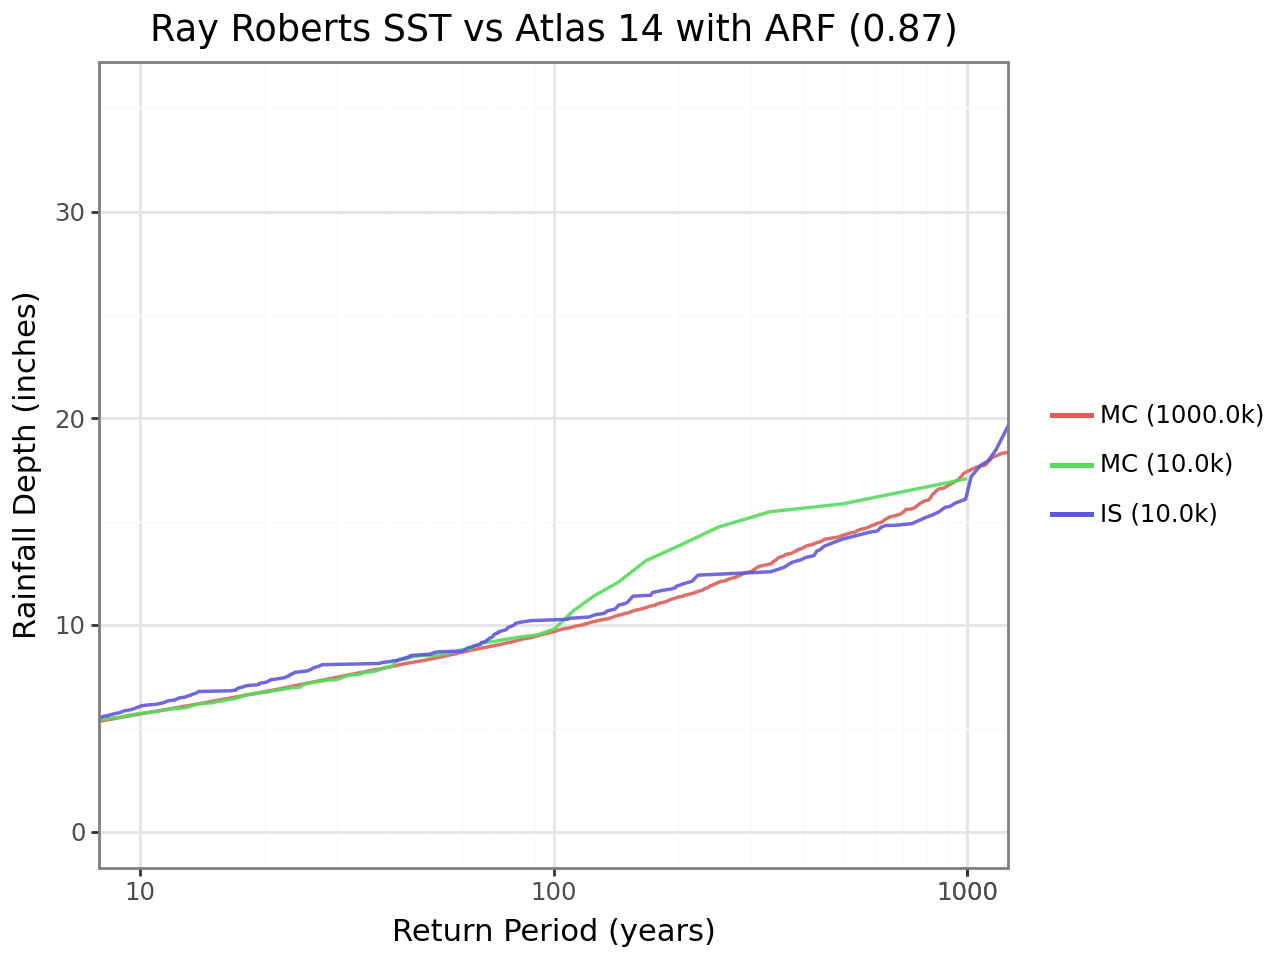

In [103]:
g = plot_freq_curve([df_prob_mc_0, df_prob_mc, df_prob_is], [f'MC ({n_sim_mc/1000}k)', f'MC ({n_sim_is/1000}k)', f'IS ({n_sim_is/1000}k)'])
g.show()

In [104]:
df = pd.read_csv('./data/a14_aep.csv')
df['AEP_mm'] = df['AEP_mm']*0.0393701*0.87
df

,RP,AEP_mm
0,1,3.654687
1,2,4.394530
2,5,5.531696
3,10,6.535279
4,25,7.970437
5,50,9.135005
6,100,10.354376
7,200,11.745006
8,500,13.659692
9,1000,15.310638


In [105]:
from plotnine import geom_point, aes

g += geom_point(
    data=df,
    mapping=aes(x='RP', y='AEP_mm'),  # <-- legend label
    shape='o',
    size=2,
    stroke=0.3,
    fill='red'
)

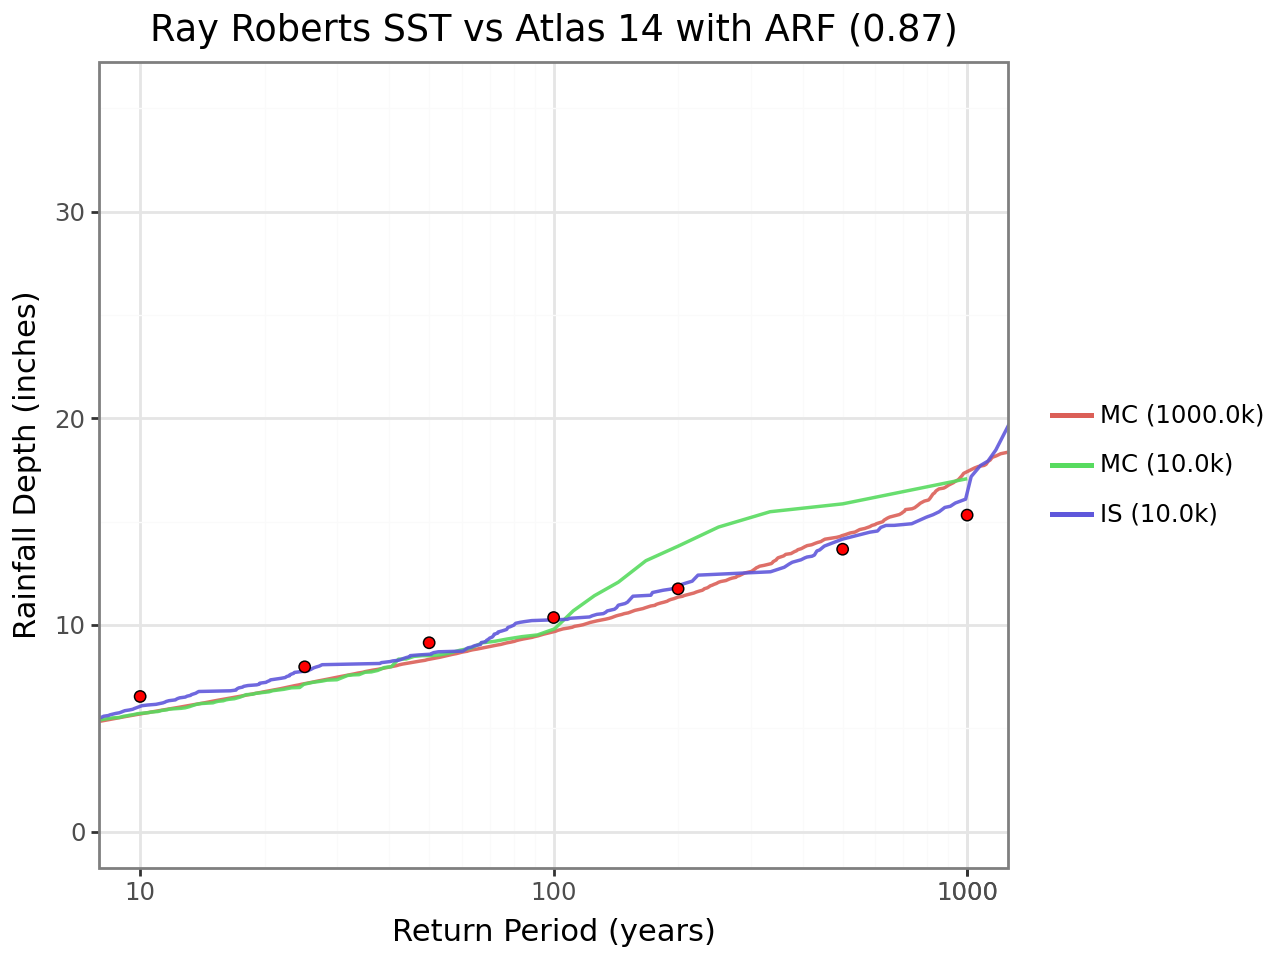

In [106]:
g

In [111]:
import numpy as np
import pandas as pd

# Example return periods of interest
target_rps = [1, 2, 5, 10, 25, 50, 100,200, 500, 1000]

# Sort the DataFrame by return period (ascending)
df_sorted = df_prob_is.sort_values(by='return_period')

# Interpolate depth at each target return period
depths_at_rps = np.interp(target_rps,
                          df_sorted['return_period'],
                          df_sorted['depth'])

# Create a result DataFrame
df_return_depth = pd.DataFrame({
    'return_period': target_rps,
    'depth': depths_at_rps
})

print(df_return_depth)

   return_period      depth
0              1   0.000000
1              2   3.119866
2              5   4.792855
3             10   6.061692
4             25   7.773528
5             50   8.580987
6            100  10.227386
7            200  11.905741
8            500  14.149983
9           1000  16.376452


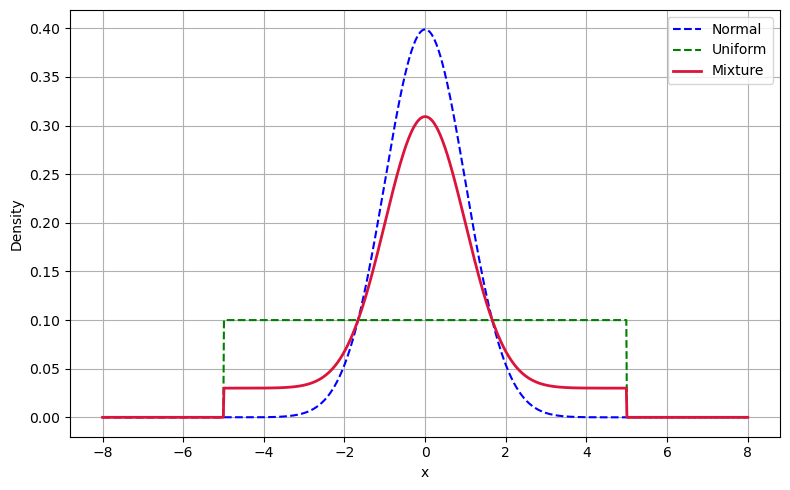

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform

# Parameters
p = 0.7  # weight for normal
mean = 0
std = 1
domain_min, domain_max = -5, 5
domain_length = domain_max - domain_min

# Create x-axis values
x = np.linspace(-8, 8, 1000)

# Component PDFs
pdf_normal = norm.pdf(x, loc=mean, scale=std)
pdf_uniform = uniform.pdf(x, loc=domain_min, scale=domain_length)

# Mixture PDF
pdf_mixture = p * pdf_normal + (1 - p) * pdf_uniform

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x, pdf_normal, label='Normal', linestyle='--', color='blue')
plt.plot(x, pdf_uniform, label='Uniform', linestyle='--', color='green')
plt.plot(x, pdf_mixture, label='Mixture', linewidth=2, color='crimson')
plt.title("")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
